##  Importing important Libraries 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

## Loading data 

In [2]:
f = pd.read_csv("Retail.csv", encoding='ANSI')

In [3]:
f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,12/1/2010 8:26,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,12/1/2010 8:26,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,12/1/2010 8:26,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,12/1/2010 8:26,3.39,17850.0,United Kingdom


# Data Pre-Processing

## Changing Date format  

In [4]:
f['InvoiceDate'] = pd.to_datetime(f['InvoiceDate'])

In [5]:
f.head()

,InvoiceNo,StockCode,Description,Quantity,InvoiceDate,UnitPrice,CustomerID,Country
0,536365,85123A,WHITE HANGING HEART T-LIGHT HOLDER,6,2010-12-01 08:26:00,2.55,17850.0,United Kingdom
1,536365,71053,WHITE METAL LANTERN,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
2,536365,84406B,CREAM CUPID HEARTS COAT HANGER,8,2010-12-01 08:26:00,2.75,17850.0,United Kingdom
3,536365,84029G,KNITTED UNION FLAG HOT WATER BOTTLE,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom
4,536365,84029E,RED WOOLLY HOTTIE WHITE HEART.,6,2010-12-01 08:26:00,3.39,17850.0,United Kingdom


In [6]:
perf6m = f[f['InvoiceDate']< '2011-01-01'] #6month performance
hist6m  = f[f['InvoiceDate']>'2011-01-01'] # 6 month future

In [7]:
# Getting Unique Customer ID
user = pd.DataFrame(perf6m['CustomerID'].unique())
user.columns = ['CustomerID']

In [8]:
#create a dataframe with customer id and first purchase date in hist6m
first_purchase = hist6m.groupby('CustomerID').InvoiceDate.min().reset_index()
first_purchase.columns = ['CustomerID','MinPurchaseDate']
#create a dataframe with customer id and last purchase date in perf6m
last_purchase = perf6m.groupby('CustomerID').InvoiceDate.max().reset_index()
last_purchase.columns = ['CustomerID','MaxPurchaseDate']

In [9]:
#merge two dataframes
purchase_dates = pd.merge(last_purchase,first_purchase,on='CustomerID',how='left')
#calculate the time difference in days:
purchase_dates['NextPurchaseDay'] = (purchase_dates['MinPurchaseDate'] - purchase_dates['MaxPurchaseDate']).dt.days
#merge with hist6m 
user = pd.merge(user, purchase_dates[['CustomerID','NextPurchaseDay']],on='CustomerID',how='left')


In [10]:
#Handeling Null Values
user.isnull().sum()

CustomerID           1
NextPurchaseDay    129
dtype: int64

In [11]:
user = user.fillna(999)

In [12]:
#create a dataframe with CustomerID and Invoice Date
day_order = perf6m[['CustomerID','InvoiceDate']]
#convert Invoice Datetime to day
day_order['InvoiceDay'] = perf6m['InvoiceDate'].dt.date
day_order = day_order.sort_values(['CustomerID','InvoiceDate'])
#drop duplicates
day_order = day_order.drop_duplicates(subset=['CustomerID','InvoiceDay'],keep='first')

<ipython-input-12-7ab5065078d6>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  day_order['InvoiceDay'] = perf6m['InvoiceDate'].dt.date


In [13]:
#shifting last 3 purchase dates
day_order['PrevInvoiceDate'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(1)
day_order['T2InvoiceDate'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(2)
day_order['T3InvoiceDate'] = day_order.groupby('CustomerID')['InvoiceDay'].shift(3)


In [14]:
day_order['DayDiff'] = (day_order['InvoiceDay'] - day_order['PrevInvoiceDate']).dt.days
day_order['DayDiff2'] = (day_order['InvoiceDay'] - day_order['T2InvoiceDate']).dt.days
day_order['DayDiff3'] = (day_order['InvoiceDay'] - day_order['T3InvoiceDate']).dt.days

In [15]:
day_diff = day_order.groupby('CustomerID').agg({'DayDiff': ['mean','std']}).reset_index()
day_diff.columns = ['CustomerID', 'DayDiffMean','DayDiffStd']

In [16]:
day_order_last = day_order.drop_duplicates(subset=['CustomerID'],keep='last')

In [17]:
day_order_last = day_order_last.dropna()
day_order_last = pd.merge(day_order_last, day_diff, on='CustomerID')
user = pd.merge(user, day_order_last[['CustomerID','DayDiff','DayDiff2','DayDiff3','DayDiffMean','DayDiffStd']], on='CustomerID')
#create class1 as a copy of user before applying get_dummies
class1= user.copy()
class1= pd.get_dummies(class1)

In [18]:
class1['NextPurchaseDayRange'] = 2
class1.loc[class1.NextPurchaseDay>10,'NextPurchaseDayRange'] = 1
class1.loc[class1.NextPurchaseDay>50,'NextPurchaseDayRange'] = 0

<AxesSubplot:>

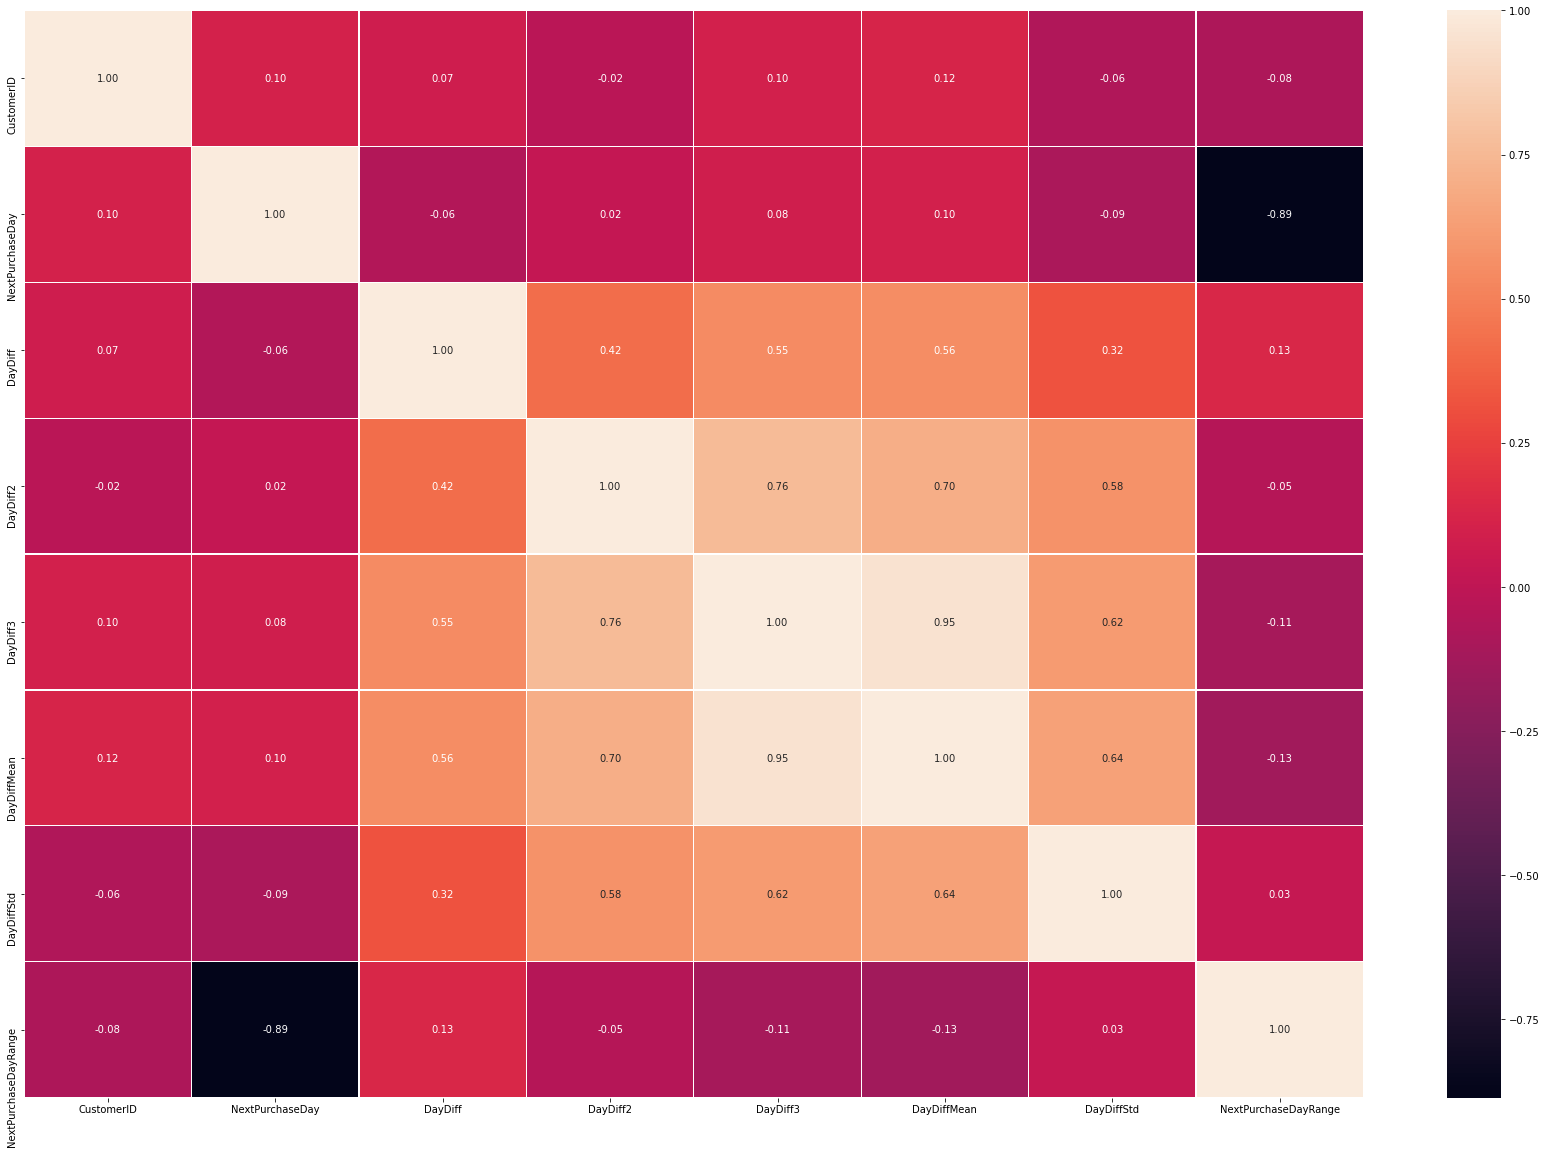

In [19]:
corr = class1[class1.columns].corr()
plt.figure(figsize = (30,20))
sns.heatmap(corr, annot = True, linewidths=0.2, fmt=".2f")


# PCA started(Principal Component Analysis

In [20]:
print("Variance in x =",np.var(class1))

Variance in x = CustomerID              2.822119e+06
NextPurchaseDay         3.925289e+02
DayDiff                 6.382222e+00
DayDiff2                1.162333e+01
DayDiff3                1.468889e+01
DayDiffMean             1.519256e+00
DayDiffStd              2.612675e+00
NextPurchaseDayRange    1.155556e-01
dtype: float64


In [21]:
class12 = np.cov(class1.T) 

In [22]:
values, vecs = np.linalg.eig(class12)      # values, vecs

# Make a list of (eigenvalue, eigenvector) tuples
eigen_pairs = [(np.abs(values.real[i]), vecs.real[:, i]) for i in range(len(values.real))]

#Sort the (eigenvalue, eigenvector) tuples from high to low
eigen_pairs.sort(key=lambda k: k[0], reverse=True)

In [23]:
w = np.hstack((eigen_pairs[0][1][:, np.newaxis], eigen_pairs[1][1][:, np.newaxis]))
print('Matrix W:\n', w)

Matrix W:
 [[ 9.99999221e-01 -1.22088103e-03]
 [ 1.21796759e-03  9.99699781e-01]
 [ 1.09877220e-04 -8.07814361e-03]
 [-3.59229809e-05  4.75614427e-03]
 [ 2.24192743e-04  1.43799339e-02]
 [ 8.60110685e-05  5.44000743e-03]
 [-6.02784201e-05 -6.54323634e-03]
 [-1.64480308e-05 -1.52246542e-02]]


# Modeling started With PCA

In [24]:
from sklearn.metrics import classification_report,confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from __future__ import division
from sklearn.cluster import KMeans

In [25]:
#import machine learning related libraries
from sklearn.svm import SVC
from sklearn.multioutput import MultiOutputClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import KFold, cross_val_score, train_test_split


In [26]:
#train & test split
X, y = class1.drop('NextPurchaseDayRange',axis=1), class1.NextPurchaseDayRange
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
# Fit on training set only.
scaler.fit(X_train)
# Apply transform to both the training set and the test set.
train_img = scaler.transform(X_train)
test_img = scaler.transform(X_test)

In [27]:
from sklearn.decomposition import PCA
# Make an instance of the Model
pca = PCA(.95)

In [28]:
pca.fit(X_train)

PCA(n_components=0.95)

In [29]:
X_train = pca.transform(X_train)
X_test= pca.transform(X_test)

In [30]:
#create an array of models
models = []
models.append(("LR",LogisticRegression()))
models.append(("NB",GaussianNB()))
models.append(("RF",RandomForestClassifier()))
models.append(("SVC",SVC()))
models.append(("Dtree",DecisionTreeClassifier()))
models.append(("KNN",KNeighborsClassifier()))

#measure the accuracy 
for name,model in models:
    kfold = KFold(n_splits=2)
    result = cross_val_score(model,X_train,y_train, cv = kfold,scoring = "accuracy")
    print(name, result)

LR [0.91666667 0.75      ]
NB [0.91666667 0.75      ]
RF [0.83333333 0.75      ]
SVC [0.91666667 0.75      ]
Dtree [0.83333333 0.75      ]
KNN [0.91666667 0.75      ]
